# Monitoring Deforestation with SageMaker Geospatial Capabilities


This notebook runs with Kernel Geospatial 1.0. Note that the following policies need to be attached to the execution role that you used to run this notebook:

- AmazonSageMakerFullAccess
- AmazonSageMakerGeospatialFullAccess

You can see the policies attached to the role in the IAM console under the permissions tab. If required, add the roles using the 'Add Permissions' button. 

In addition to these policies, ensure that the execution role's trust policy allows the SageMaker-GeoSpatial service to assume the role. This can be done by adding the following trust policy using the 'Trust relationships' tab:
```
{
    "Version": "2012-10-17",
    "Statement": [
        {
            "Effect": "Allow",
            "Principal": {
                "Service": [
                    "sagemaker.amazonaws.com",
                    "sagemaker-geospatial.amazonaws.com"
                ]
            },
            "Action": "sts:AssumeRole"
        }
    ]
}
```

**Contents**

* [Setup SageMaker geospatial capabilities](#1)
* [Query and access Data](#2)
* [Start an Earth Observation Job (EOJ) to calculate the NVDI](#3)
* [Visualize EOJ inputs and outputs in FourSquare Studio](#4)
* [Extract the NDVI results](#5)
* [Measure the dense forest area](#6)



<a id='1'></a>

## Setup SageMaker geospatial capabilities

In [2]:
import datetime as dt
import os
import time
from glob import glob
from urllib import request
from urllib.parse import urlparse

import boto3
import cv2
import imageio.v2 as imageio
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import matplotlib.colors
import numpy as np
import sagemaker
import sagemaker_geospatial_map
import tifffile
from botocore import UNSIGNED
from botocore.config import Config
from IPython.display import HTML

In [3]:
session = boto3.Session()
execution_role = sagemaker.get_execution_role()
sg_client = session.client(service_name="sagemaker-geospatial")

<a id='2'></a>

## Query and access data

Query the geospatial data with area of interest (AOI), time range and cloud cover filter.  In this example we will monitor a location near Novo Progresso, Brazil.  We enter the coordinates for this location, the time that we are interested, and the maximium cloud coverage.  

In [4]:
coords = [[-55.9, -7.5], [-55.2, -7.5], [-55.2, -7.8], [-55.9, -7.8], [-55.9, -7.5]]
timestart = "2020-01-01T00:00:00Z"
timeend = "2022-09-01T00:00:00Z"
maxclouds = 1  #

In [5]:
dc = sg_client.list_raster_data_collections()
for k in dc["RasterDataCollectionSummaries"]:
    print()
    print(f"Dataset:     {k['Name']}\nDescription: {k['Description']}\nArn:         {k['Arn']}")


Dataset:     Landsat Collection 2 Level-2 Science Products
Description: Landsat Collection 2 includes scene-based global Level-2 surface reflectance and surface temperature science products.,
Arn:         arn:aws:sagemaker-geospatial:us-west-2:378778860802:raster-data-collection/public/gmqa64dcu2g9ayx1

Dataset:     Sentinel 2 L2A COGs
Description: Sentinel-2a and Sentinel-2b imagery, processed to Level 2A (Surface Reflectance) and converted to Cloud-Optimized GeoTIFFs
Arn:         arn:aws:sagemaker-geospatial:us-west-2:378778860802:raster-data-collection/public/nmqj48dcu3g7ayw8


In [6]:
search_rdc_args = {
    "Arn": "arn:aws:sagemaker-geospatial:us-west-2:378778860802:raster-data-collection/public/nmqj48dcu3g7ayw8",  # sentinel-2 L2A COG
    "RasterDataCollectionQuery": {
        "AreaOfInterest": {
            "AreaOfInterestGeometry": {"PolygonGeometry": {"Coordinates": [coords]}}
        },
        "TimeRangeFilter": {
            "StartTime": timestart,
            "EndTime": timeend,
        },
        "PropertyFilters": {
            "Properties": [
                {"Property": {"EoCloudCover": {"LowerBound": 0, "UpperBound": maxclouds}}}
            ],
            "LogicalOperator": "AND",
        },
        "BandFilter": ["visual"],
    },
}

tci_urls = []
data_manifests = []
while search_rdc_args.get("NextToken", True):
    search_result = sg_client.search_raster_data_collection(**search_rdc_args)
    if search_result.get("NextToken"):
        data_manifests.append(search_result)
    for item in search_result["Items"]:
        tci_url = item["Assets"]["visual"]["Href"]
        print(tci_url)
        tci_urls.append(tci_url)

    search_rdc_args["NextToken"] = search_result.get("NextToken")

https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/21/M/XM/2022/7/S2A_21MXM_20220730_0_L2A/TCI.tif
https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/21/M/XM/2022/7/S2B_21MXM_20220725_0_L2A/TCI.tif
https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/21/M/XM/2022/7/S2A_21MXM_20220720_0_L2A/TCI.tif
https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/21/M/XM/2022/7/S2B_21MXM_20220705_0_L2A/TCI.tif
https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/21/M/XM/2022/6/S2A_21MXM_20220620_0_L2A/TCI.tif
https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/21/M/XM/2022/5/S2A_21MXM_20220531_0_L2A/TCI.tif
https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/21/M/XM/2022/5/S2B_21MXM_20220526_0_L2A/TCI.tif
https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/21/M/XM/2021/8/S2B_21MXM_20210819_0_L2A/TCI.tif
https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentine

Great!  We have images that match our area of interest, time range, and cloud filter.  Note that the total number of images found will depend on the data query.  

In [7]:
print(f"total number of results found that match the filter criteria: {len(tci_urls)}")

total number of results found that match the filter criteria: 25


Now, let's download one of the results and plot it in the notebook. This is used as a sanity check to ensure the image covers the area of interest, time range, and cloud coverage. 

Downloaded image: S2B_21MXM_20220725_0_L2A


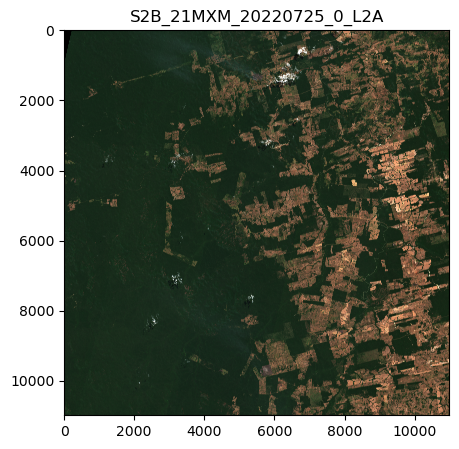

In [8]:
# Check one example.
image_dir = "./images/data"
os.makedirs(image_dir, exist_ok=True)

tci_url = tci_urls[1]
img_id = tci_url.split("/")[-2]
tci_path = image_dir + "/" + img_id + "_TCI.tif"
response = request.urlretrieve(tci_url, tci_path)
print("Downloaded image: " + img_id)

tci = tifffile.imread(tci_path)
fig, ax = plt.subplots(figsize=(5, 5))
plt.title(img_id)
plt.imshow(tci)
plt.show()

<a id='3'></a>
## Start an Earth Observation Job (EOJ) to calculate the Normalized Difference Vegetation Index (NDVI)

First, let's check to see what spectral bands are available in the dataset

In [9]:
sg_client.get_raster_data_collection(
    Arn="arn:aws:sagemaker-geospatial:us-west-2:378778860802:raster-data-collection/public/nmqj48dcu3g7ayw8"
)["ImageSourceBands"]

['coastal',
 'blue',
 'green',
 'red',
 'rededge1',
 'rededge2',
 'rededge3',
 'nir',
 'nir08',
 'nir09',
 'swir16',
 'swir22',
 'aot',
 'wvp',
 'scl']

We can get more information on the bands by visiting the [sentinel website](https://sentinels.copernicus.eu/web/sentinel/user-guides/sentinel-2-msi/resolutions/spatial).  Here we will be using band 8 - nir and band 4 - red.  Both of these bands have a 10 m spatial resolution.  The bands will be used to calculate the Normalized Difference Vegetation Index (NDVI).  The index is a ratio between -1 to +1, where values near -1 have low vegetation reflectance and values near +1 have high vegetation reflectance.  Healthy vegetation (chlorophyll) will reflect more near infrared and green light while absorbling more red and blue light.  We will impliment the NDVI calculation using BandMath EOJ job and specify the equation in the EOJ config.  

In [10]:
# Perform land cover segmentation on images returned from the sentinel dataset.
#
# This Earth Observation Job will take ~20 minutes to complete

eoj_input_config = {
    "RasterDataCollectionQuery": {
        "RasterDataCollectionArn": "arn:aws:sagemaker-geospatial:us-west-2:378778860802:raster-data-collection/public/nmqj48dcu3g7ayw8",
        "AreaOfInterest": {
            "AreaOfInterestGeometry": {"PolygonGeometry": {"Coordinates": [coords]}}
        },
        "TimeRangeFilter": {
            "StartTime": timestart,
            "EndTime": timeend,
        },
        "PropertyFilters": {
            "Properties": [
                {"Property": {"EoCloudCover": {"LowerBound": 0, "UpperBound": maxclouds}}}
            ],
            "LogicalOperator": "AND",
        },
    }
}


eoj_config = {
    "BandMathConfig": {
        "CustomIndices": {
            "Operations": [{"Name": "veggie", "Equation": "(nir - red) / (nir + red)"}]
        }
    }
}

response = sg_client.start_earth_observation_job(
    Name="brazil-deforestation",
    InputConfig=eoj_input_config,
    JobConfig=eoj_config,
    ExecutionRoleArn=execution_role,
)

### Monitor the EOJ status.

In [11]:
eoj_arn = response["Arn"]
job_details = sg_client.get_earth_observation_job(Arn=eoj_arn)
{k: v for k, v in job_details.items() if k in ["Arn", "Status", "DurationInSeconds"]}

{'Arn': 'arn:aws:sagemaker-geospatial:us-west-2:431615879134:earth-observation-job/qjhij3bypkgg',
 'DurationInSeconds': 0,
 'Status': 'INITIALIZING'}

We can also impliment a loop to check on the EOJ status

In [12]:
def EOJwaiter(arn, max_check=1000, max_sleep=60):
    status = None
    print(f"##### Checking Status on EOJ: {arn} #####")
    tic = time.time()

    for i in range(max_check):
        _ = sg_client.get_earth_observation_job(Arn=arn)["Status"]

        if status != _:
            if status is not None:
                print(f"Step Duration: {time.time()-tic:.2f} seconds")
                tic = time.time()

            status = _
            print(status)

            if status == "COMPLETED":
                break
        else:
            print(".", end="", flush=True)
        time.sleep(max_sleep)

In [13]:
EOJwaiter(eoj_arn)

##### Checking Status on EOJ: arn:aws:sagemaker-geospatial:us-west-2:431615879134:earth-observation-job/qjhij3bypkgg #####
INITIALIZING
Step Duration: 61.10 seconds
IN_PROGRESS
..................Step Duration: 1149.68 seconds
COMPLETED


<a id='4'></a>

## Visualize EOJ inputs and outputs using the geospatial client

In [14]:
# Creates an instance of the map to add EOJ input/ouput layer
map = sagemaker_geospatial_map.create_map({"is_raster": True})
map.set_sagemaker_geospatial_client(sg_client)

In [15]:
# Render the map
map.render()

SyncWidgetMap(raster={'stacSearchUrl': AnyHttpUrl('https://domain-name/raster', )}, style={'height': '100%', '…

In [17]:
# Visualize AOI
config = {"label": "Novo Progresso AOI"}
aoi_layer = map.visualize_eoj_aoi(Arn=eoj_arn, config=config)
time.sleep(20)

In [18]:
# Visualize input.
time_range_filter = {
    "start_date": timestart,
    "end_date": timeend,
}
config = {"label": "Input"}

input_layer = map.visualize_eoj_input(
    Arn=eoj_arn, config=config, time_range_filter=time_range_filter
)
time.sleep(20)

In [19]:
# Visualize output, EOJ needs to be in completed status.
time_range_filter = {
    "start_date": timestart,
    "end_date": timeend,
}
config = {"preset": "singleBand", "band_name": "veggie"}
output_layer = map.visualize_eoj_output(
    Arn=eoj_arn, config=config, time_range_filter=time_range_filter
)
time.sleep(20)

<a id='5'></a>
## Extract the NDVI band math results

To get the output from the EOJ job we need to export it to s3.  Here we provide an export location and start the export job.  Note that the export job will take ~5 minutes to complete.

In [20]:
sagemaker_session = sagemaker.Session()
s3_bucket_name = sagemaker_session.default_bucket()  # Replace with your own bucket if needed
s3_bucket = session.resource("s3").Bucket(s3_bucket_name)
prefix = "eoj_deforestation_ndvi"  # Replace with the S3 prefix desired
export_bucket_and_key = f"s3://{s3_bucket_name}/{prefix}/"

eoj_output_config = {"S3Data": {"S3Uri": export_bucket_and_key}}
export_response = sg_client.export_earth_observation_job(
    Arn=eoj_arn,
    ExecutionRoleArn=execution_role,
    OutputConfig=eoj_output_config,
    ExportSourceImages=False,
)  #

In [21]:
print(f"Data will be exported to:  {export_bucket_and_key}")

Data will be exported to:  s3://sagemaker-us-west-2-431615879134/eoj_deforestation_ndvi/


In [22]:
# Monitor the export job status
export_job_details = sg_client.get_earth_observation_job(Arn=export_response["Arn"])
{k: v for k, v in export_job_details.items() if k in ["Arn", "ExportStatus", "DurationInSeconds"]}

{'Arn': 'arn:aws:sagemaker-geospatial:us-west-2:431615879134:earth-observation-job/qjhij3bypkgg',
 'DurationInSeconds': 1304,
 'ExportStatus': 'IN_PROGRESS'}

Again we can impliment a loop to monitor the status of the export

In [23]:
def EOJexportwaiter(arn, max_check=1000, max_sleep=60):
    status = None
    print(f"##### Checking Export Status on EOJ: {arn} #####")
    tic = time.time()

    for i in range(max_check):
        _ = sg_client.get_earth_observation_job(Arn=arn)["ExportStatus"]

        if status != _:
            if status is not None:
                print(f"Step Duration: {time.time()-tic:.2f} seconds")
                tic = time.time()

            status = _
            print(status)

            if status == "SUCCEEDED":
                break
        else:
            print(".", end="", flush=True)
        time.sleep(max_sleep)

In [24]:
EOJexportwaiter(eoj_arn)

##### Checking Export Status on EOJ: arn:aws:sagemaker-geospatial:us-west-2:431615879134:earth-observation-job/qjhij3bypkgg #####
IN_PROGRESS
......Step Duration: 424.31 seconds
SUCCEEDED


<a id='6'></a>
## Measure Vegetation Index

Now with our data exported to s3, let's download the tif masks to the notebook elastic file system (EFS).  Once we download the image we can then calculate the vegetation.  We need to download the images to the file system to be able to read them into memory and to calculate the total area of vegetation.  

In [ ]:
# Download band math masks
mask_dir = "./masks/deforestation"
os.makedirs(mask_dir, exist_ok=True)
image_paths = []
for s3_object in s3_bucket.objects.filter(Prefix=prefix).all():
    path, filename = os.path.split(s3_object.key)
    if "output" in path:
        mask_name = mask_dir + "/" + filename
        s3_bucket.download_file(s3_object.key, mask_name)
        print("Downloaded mask: " + mask_name)

# Download source images for visualization
for tci_url in tci_urls:
    url_parts = urlparse(tci_url)
    img_id = url_parts.path.split("/")[-2]
    tci_download_path = image_dir + "/" + img_id + "_TCI.tif"
    cogs_bucket = session.resource(
        "s3", config=Config(signature_version=UNSIGNED, region_name="us-west-2")
    ).Bucket(url_parts.hostname.split(".")[0])
    cogs_bucket.download_file(url_parts.path[1:], tci_download_path + ".1")
    print("Downloaded image: " + img_id)

print("Downloads complete.")  #

### Extract area of vegetation.

In [26]:
image_files = glob("./images/data/*.tif.1")
mask_files = glob("./masks/deforestation/*.tif")
image_files.sort(key=lambda x: x.split("MXM_")[1])
mask_files.sort(key=lambda x: x.split("MXM_")[1])

In [27]:
overlay_dir = "./masks/veg-index-overlay"
os.makedirs(overlay_dir, exist_ok=True)

veg_areas = []
mask_dates = []
thresh = 0.4  # https://www.usgs.gov/special-topics/remote-sensing-phenology/science/ndvi-foundation-remote-sensing-phenology

for image_file, mask_file in zip(image_files, mask_files):
    image_id = image_file.split("/")[-1].split("_TCI")[0]
    mask_id = mask_file.split("/")[-1].split("_veggie.tif")[0]
    mask_date = mask_id.split("_")[2]
    if image_id == mask_id:
        print(image_id)
        mask_dates.append(mask_date)
        image = tifffile.imread(image_file)  # (10980 x 10980 x 3)
        image_ds = cv2.resize(
            image, (2000, 2000), interpolation=cv2.INTER_LINEAR
        )  # (2000 x 2000 x 3)
        mask = tifffile.imread(mask_file)  # 10980 x 10980 (10 m per pixel)
        veg_mask = (mask > thresh).astype(np.uint8)
        veg_mask = veg_mask[
            2000:, :
        ]  # sample image to remove missing path in the north west corner
        veg_area = (
            veg_mask.sum() * 10 * 10 / (1000 * 1000)
        )  # calculate the surface area, 10m per pixel
        veg_areas.append(veg_area)

        cmap = matplotlib.colors.ListedColormap(["red", "green"])
        f, axarr = plt.subplots(1, 2, figsize=(12, 5))
        axarr[0].imshow(image[2000:, :])
        axarr[0].axis("off")
        axarr[1].imshow(veg_mask, cmap=cmap)
        axarr[1].axis("off")

        # plt.figure(figsize=(10, 10))
        # plt.imshow(image[2000:, :])
        # plt.imshow(mask[2000:, :], cmap="PRGn", alpha=0.4)
        f.suptitle(
            f"{image_id}\nTotal Area = {veg_area:.1f} sq km\nDate = {mask_date[0:4]}-{mask_date[4:6]}-{mask_date[6:8]} "
        )
        overlay_file = overlay_dir + "/" + mask_date + ".png"
        f.savefig(overlay_file, dpi=80, bbox_inches="tight")
        plt.close()

S2A_21MXM_20200620_0_L2A
S2B_21MXM_20200625_0_L2A
S2B_21MXM_20200705_0_L2A
S2B_21MXM_20200715_0_L2A
S2A_21MXM_20200720_0_L2A
S2A_21MXM_20200730_0_L2A
S2A_21MXM_20200809_0_L2A
S2B_21MXM_20200814_0_L2A
S2A_21MXM_20200819_0_L2A
S2A_21MXM_20210526_0_L2A
S2B_21MXM_20210630_0_L2A
S2A_21MXM_20210705_0_L2A
S2A_21MXM_20210715_0_L2A
S2B_21MXM_20210720_0_L2A
S2A_21MXM_20210725_0_L2A
S2A_21MXM_20210804_0_L2A
S2B_21MXM_20210809_0_L2A
S2B_21MXM_20210819_0_L2A
S2B_21MXM_20220526_0_L2A
S2A_21MXM_20220531_0_L2A
S2A_21MXM_20220620_0_L2A
S2B_21MXM_20220705_0_L2A
S2A_21MXM_20220720_0_L2A
S2B_21MXM_20220725_0_L2A
S2A_21MXM_20220730_0_L2A


We have produced output plots using the satellite image overlayed with the vegetation index at a transparency of 40%.  Let's take a look at a single image

In [ ]:
HTML('<img src="./masks/veg-index-overlay/20220531.png">')

Now let's split the data by year so we can compare 2020, 2021, and 2022. 

In [29]:
a = []
t = []
years = ["2020", "2021", "2022"]
for y in years:
    a_ = []
    t_ = []
    for i, m in enumerate(mask_dates):
        if m[0:4] == y:
            t_.append(dt.datetime.strptime("1900" + m[4:], "%Y%m%d").date())
            a_.append(veg_areas[i])

    a.append(a_)
    t.append(t_)

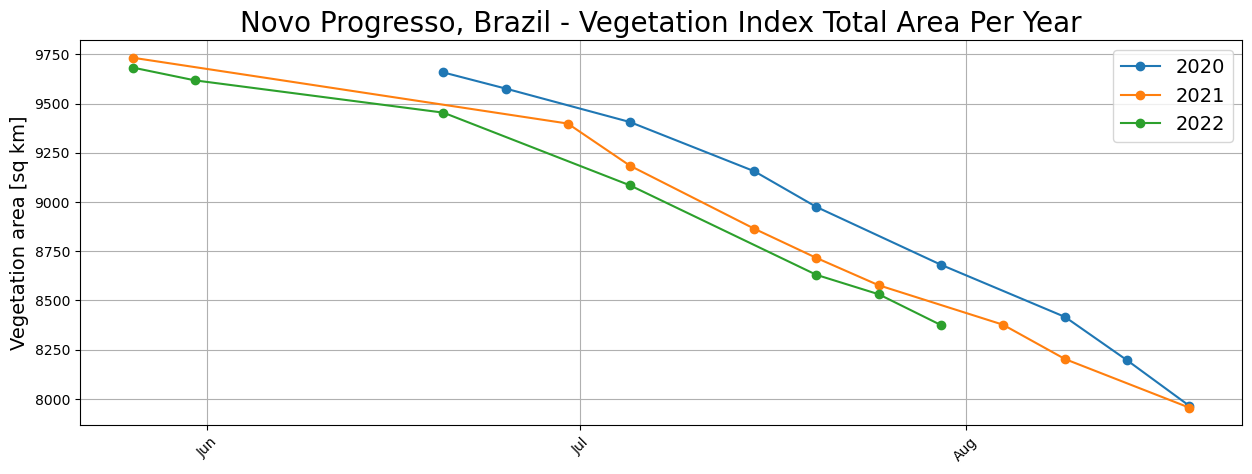

In [30]:
plt.figure(figsize=(15, 5))
plt.title("Novo Progresso, Brazil - Vegetation Index Total Area Per Year", fontsize=20)
plt.xticks(rotation=45)
plt.ylabel("Vegetation area [sq km]", fontsize=14)
plt.plot(t[0], a[0], marker="o", label="2020")
plt.plot(t[1], a[1], marker="o", label="2021")
plt.plot(t[2], a[2], marker="o", label="2022")
# Make ticks on occurrences of each month:
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
# Get only the month to show in the x-axis:
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%b"))
plt.grid("on")
plt.legend(loc="best", fontsize=14)
plt.show()

The plot above was produced using geospatial images alone.  We can monitor how the total area of the vegetation index is changing over time and compare this to previous years.  In this plot we show how year 2020, 2021, and 2022 are slightly different.  There is a clear seasonal trend where the spring vegetation decreases as we approach fall / winter.  As deforestation continues we see the yearly curves move down (less area) each year. Note that the same number of images for each year are different.  This is due to the cloud filter where some of the images acquired during the time range of interest did not meet the cloud coverage constraints.

If we take a closer look at the images that were collected in 2020, 2021, and 2022 we can see the change in the vegetation.  Here the 3 image gif shows the visual image with the vegetation index.  We can see that the vegetation area decreases as we progress from 2020 to 2022

In [31]:
frames = []
filenames = glob("./masks/veg-index-overlay/*0705.png")
filenames.sort()

for filename in filenames:
    frames.append(imageio.imread(filename))
imageio.mimsave("deforestation.gif", frames, duration=1)

In [ ]:
HTML('<img src="./deforestation.gif">')